# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

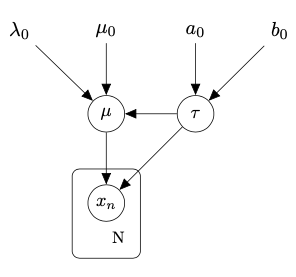

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [317]:
import numpy as np
def generate_data(mu, tau, N):
  D = np.random.normal(mu, 1/tau, N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



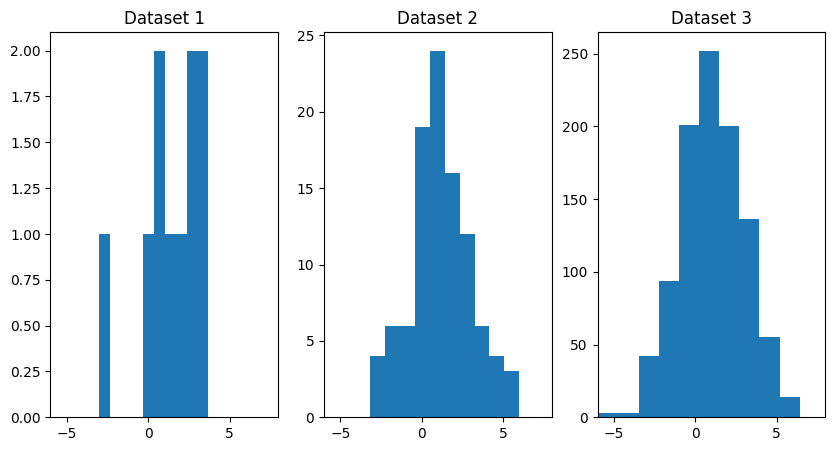

In [318]:
import matplotlib.pyplot as plt

mu = 1
tau = 0.5
num_bins = 10

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)
datasets = [dataset_1, dataset_2, dataset_3]

plt.figure(figsize=[10, 5])
for idx, dataset in enumerate(datasets):
    plt.subplot(1,3,idx+1)
    plt.xlim([-6,8])
    plt.hist(dataset, bins=num_bins)
    plt.title("Dataset " + str(idx+1))
plt.show()

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [319]:
def MAP_est(data, a_0, b_0, mu_0, lambda_0):
  N = np.shape(data)[0]
  sum_xn = np.sum(data)
  mu_map = (lambda_0 * mu_0 + sum_xn) / (N + lambda_0)
  tau_map = ((N-3)/2 + a_0) / (1/2 * np.sum((data -
            mu_map)**2) + lambda_0/2 * (mu_map - mu_0)**2 + b_0)
  return mu_map, tau_map

def ML_est(data, a_0, b_0, mu_0, lambda_0):
  mu_ml = np.mean(data)
  tau_ml = 1/np.mean(np.square(data - mu_ml))
  return mu_ml, tau_ml

### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [320]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  N = np.shape(D)[0]
  a_0_prime = N/2 + a_0
  b_0_prime = (b_0 + 1/2 * (np.sum(D**2) + lambda_0 * 
              mu_0**2) - 1/2 * (mu_0 * lambda_0 + np.sum(D))**2 / 
              (N + lambda_0))
  mu_0_prime = (lambda_0 * mu_0 + np.sum(D)) / (N + lambda_0)
  lambda_0_prime = N + lambda_0
  exact_post_dist_parameters = [a_0_prime, b_0_prime, 
                                mu_0_prime, lambda_0_prime]
  return exact_post_dist_parameters

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [321]:
# prior parameters
mu_0 = 1
lambda_0 = 4
a_0 = 0.5
b_0 = 1

Continue with a helper function that computes ELBO:


In [322]:
from scipy.special import digamma, loggamma
from scipy.special import gamma as gamma_function
sq2 = np.square
def compute_elbo(D,a_0,b_0,mu_0,lambda_0,a_N ,b_N,mu_N,lambda_N):
  N = D.shape[0]
  digamma_term = ((N-3)/2 + a_0 + a_N)*(digamma(a_N) - np.log(b_N))
  constants_term = (-0.5 * np.log(lambda_N) + lambda_N*sq2(mu_N) + 
                    a_N*(np.log(b_N)-1)-loggamma(a_N))
  fraction_term = -0.5*a_N/b_N *((N+lambda_0)/lambda_N -
                  (N+lambda_0)*sq2(mu_N) - 2*mu_N * 
                  (lambda_0*mu_0 + np.sum(D, axis=0)) + 
                  lambda_0*sq2(mu_0) + 2*b_0 + np.sum(sq2(D), axis=0))
  return digamma_term + constants_term + fraction_term
  # +f(a_0, b_0, lambda_0, D)


Now, implement the CAVI algorithm:

In [323]:
def CAVI_updates(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  N = D.shape[0]
  mu_N = 1/(N+lambda_0)*(lambda_0*mu_0 + np.sum(D, axis=0))
  lambda_N = (N+lambda_0)*a_N/b_N
  a_N = (N+1)/2 + a_0
  b_N = (b_0 +0.5*((N+lambda_0)/lambda_N + (N+lambda_0)*mu_N**2 + 
                   lambda_0*mu_0**2 + np.sum(sq2(D), axis=0) - 
                   2*mu_0*(lambda_0*mu_N + np.sum(D, axis=0))))
  return mu_N, lambda_N, a_N, b_N
  
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  initial_guess_exp_tau = a_0 / b_0
  # Convergence threshold
  threshold = 0.00001
  max_iters = 1000
  step_size = 0.1

  # The first CAVI update uses the initial guess of the expectancy of tau
  N = D.shape[0]
  mu_N = (1/(N+lambda_0)*(lambda_0*mu_0 + np.sum(D, axis=0)))
  lambda_N = (N+lambda_0)*initial_guess_exp_tau
  a_N = (N+1)/2 + a_0
  b_N = b_0 +0.5*((N+lambda_0)/lambda_N + (N+lambda_0)*sq2(mu_N) + 
                  lambda_0*sq2(mu_0) + np.sum(sq2(D), axis=0) - 
                  2*mu_0*(lambda_0*mu_N + np.sum(D, axis=0)))

  # We store the values of the parameters in each iteration
  mu_Ns = [mu_0]
  lambda_Ns = [lambda_0]
  a_Ns = [a_0]
  b_Ns = [b_0]

  # Update the value of the parameters with a step size
  mu_Ns.append(mu_Ns[-1]+step_size*(mu_N - mu_Ns[-1]))
  lambda_Ns.append(lambda_Ns[-1]+step_size*(lambda_N - lambda_Ns[-1]))
  a_Ns.append(a_Ns[-1]+step_size*(a_N - a_Ns[-1]))
  b_Ns.append(b_Ns[-1]+step_size*(b_N - b_Ns[-1]))

  # Shenanigans so that the first iteration of the while loop works
  elbo_0 = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_Ns[-1] , 
                        b_Ns[-1], mu_Ns[-1], lambda_Ns[-1])
  elbos = [elbo_0, elbo_0*(1-threshold*3)]
  i = 1
  while elbos[-2] / elbos[-1] - 1 >= threshold and i < max_iters:
    mu_N, lambda_N, a_N, b_N = CAVI_updates(D, a_0, b_0, mu_0, 
                          lambda_0, a_N , b_N, mu_N, lambda_N)
    
    mu_Ns.append(mu_Ns[-1]+step_size*(mu_N - mu_Ns[-1]))
    lambda_Ns.append(lambda_Ns[-1]+step_size*(lambda_N - lambda_Ns[-1]))
    a_Ns.append(a_Ns[-1]+step_size*(a_N - a_Ns[-1]))
    b_Ns.append(b_Ns[-1]+step_size*(b_N - b_Ns[-1]))

    elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_Ns[-1] ,
                b_Ns[-1], mu_Ns[-1], lambda_Ns[-1]))

    # Shenanigans so it is easier to plot later
    if i == 1:
      elbos[1] = elbos[0]
    i += 1
  return a_Ns, b_Ns, mu_Ns, lambda_Ns, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


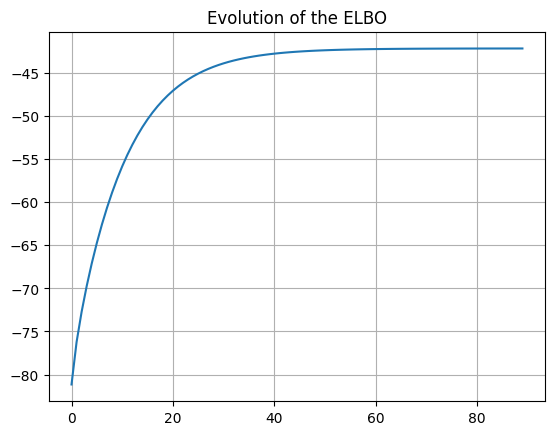

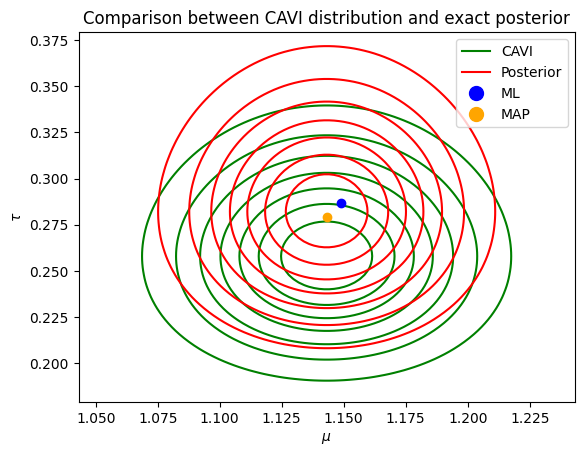

In [324]:
from scipy.stats import norm
from scipy.stats import gamma as gamma_dist
from matplotlib.lines import Line2D

dataset = dataset_2
mu_ml, tau_ml = ML_est(dataset, a_0, b_0, mu_0, lambda_0)
mu_map, tau_map = MAP_est(dataset, a_0, b_0, mu_0, lambda_0)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0)

# Plot convergence of the ELBO
plt.plot(elbos[1:])
plt.grid(True)
plt.title("Evolution of the ELBO")
plt.show()

# Plot exact posterior and CAVI result
mus = np.linspace(mu_map - 0.1, mu_map + 0.1, 100)
taus = np.linspace(tau_map - 0.1, tau_map + 0.1, 100)
X, Y = np.meshgrid(mus,taus)

exact_post_dist_param = compute_exact_posterior(dataset, a_0,
                        b_0, mu_0, lambda_0)
cavi_param = [a_N[-1], b_N[-1], mu_N[-1], lambda_N[-1]]
cavi_distribution = gamma_dist.pdf(x=Y, a=cavi_param[0], 
                scale=1/cavi_param[1])*norm.pdf(x=X,
                loc=cavi_param[2], scale=1/cavi_param[3])
sample_tau = gamma_dist.mean(a=exact_post_dist_param[0],
            scale=1/exact_post_dist_param[1])
true_post_distribution = gamma_dist.pdf(x=Y, a=exact_post_dist_param[0],
            scale=1/exact_post_dist_param[1])*norm.pdf(x=X,
            loc=exact_post_dist_param[2], scale=1/(exact_post_dist_param[3]
            *sample_tau))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,cavi_distribution, colors="green")
cs = ax.contour(X,Y, true_post_distribution, colors="red")
ax.plot(mu_ml, tau_ml, marker="o", markeredgecolor="blue",
        markerfacecolor="blue", label="ML")
ax.plot(mu_map, tau_map, marker="o", markeredgecolor="orange",
        markerfacecolor="orange", label="MAP")
plt.xlabel("$\mu$")
plt.ylabel("$\\tau$")
plt.title("Comparison between CAVI distribution and exact posterior")
legend_elements = [Line2D([],[],color=c) for c in ["green","red"]] + [
                Line2D([0], [0], marker='o', color='blue', label='ML', 
                markerfacecolor='blue', markersize=10, ls = '')] + [
                Line2D([0], [0], marker='o', color='orange', label='MAP', 
                markerfacecolor='orange', markersize=10, ls = '')]
plt.legend(legend_elements,["CAVI", "Posterior","ML", "MAP"])

